In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score 
from sklearn.metrics import precision_recall_fscore_support, classification_report

import matplotlib.pyplot as plt
%matplotlib inline

import functools

import h5py

import altair as alt


### Environmental vars

In [2]:
P_THRESHOLD=0.5

In [3]:
DATADIR = '/data/2018-03-27'

In [4]:
print('algorithm running on data extracted from content store on {}'.format(DATADIR))

algorithm running on data extracted from content store on /data/2018-03-27


### get some data about taxons/content

In [5]:
labelled_level2 = pd.read_csv(
    os.path.join(DATADIR, 'labelled_level2.csv.gz'),
    dtype=object,
    compression='gzip'
)

In [6]:
# Create World taxon in case any items not identified 
# through doc type in clean_content are still present
labelled_level2.loc[labelled_level2['level1taxon'] == 'World', 'level2taxon'] = 'world_level1'

In [7]:
# creating categorical variable for level2taxons from values
labelled_level2['level2taxon'] = labelled_level2['level2taxon'].astype('category')

# Add 1 because of zero-indexing to get 1-number of level2taxons as numerical targets
labelled_level2['level2taxon_code'] = labelled_level2.level2taxon.astype('category').cat.codes + 1

# create dictionary of taxon category code to string label for use in model evaluation
labels_index = dict(zip((labelled_level2['level2taxon_code']),
                        labelled_level2['level2taxon']))

In [8]:
# alt.Chart(labelled_level2).mark_bar().encode(
# alt.X('level2taxon:N'),
# y='count()'
# )


In [9]:
labelled_level2.groupby('level2taxon').size().sort_values(ascending=True).iloc[:60]

level2taxon
Public services and funds for foreign nationals                         1
Domestic violence                                                       1
Public sector land use                                                  2
Byelaws                                                                 2
Forced marriage                                                         2
Secondments with government                                             2
Statutory rights                                                        3
Civil justice reform                                                    3
Criminal record disclosure                                              4
Legislative process                                                     4
Government graduate schemes                                             5
Content and publishing                                                  5
Devolution                                                              5
Boating and inland waterwa

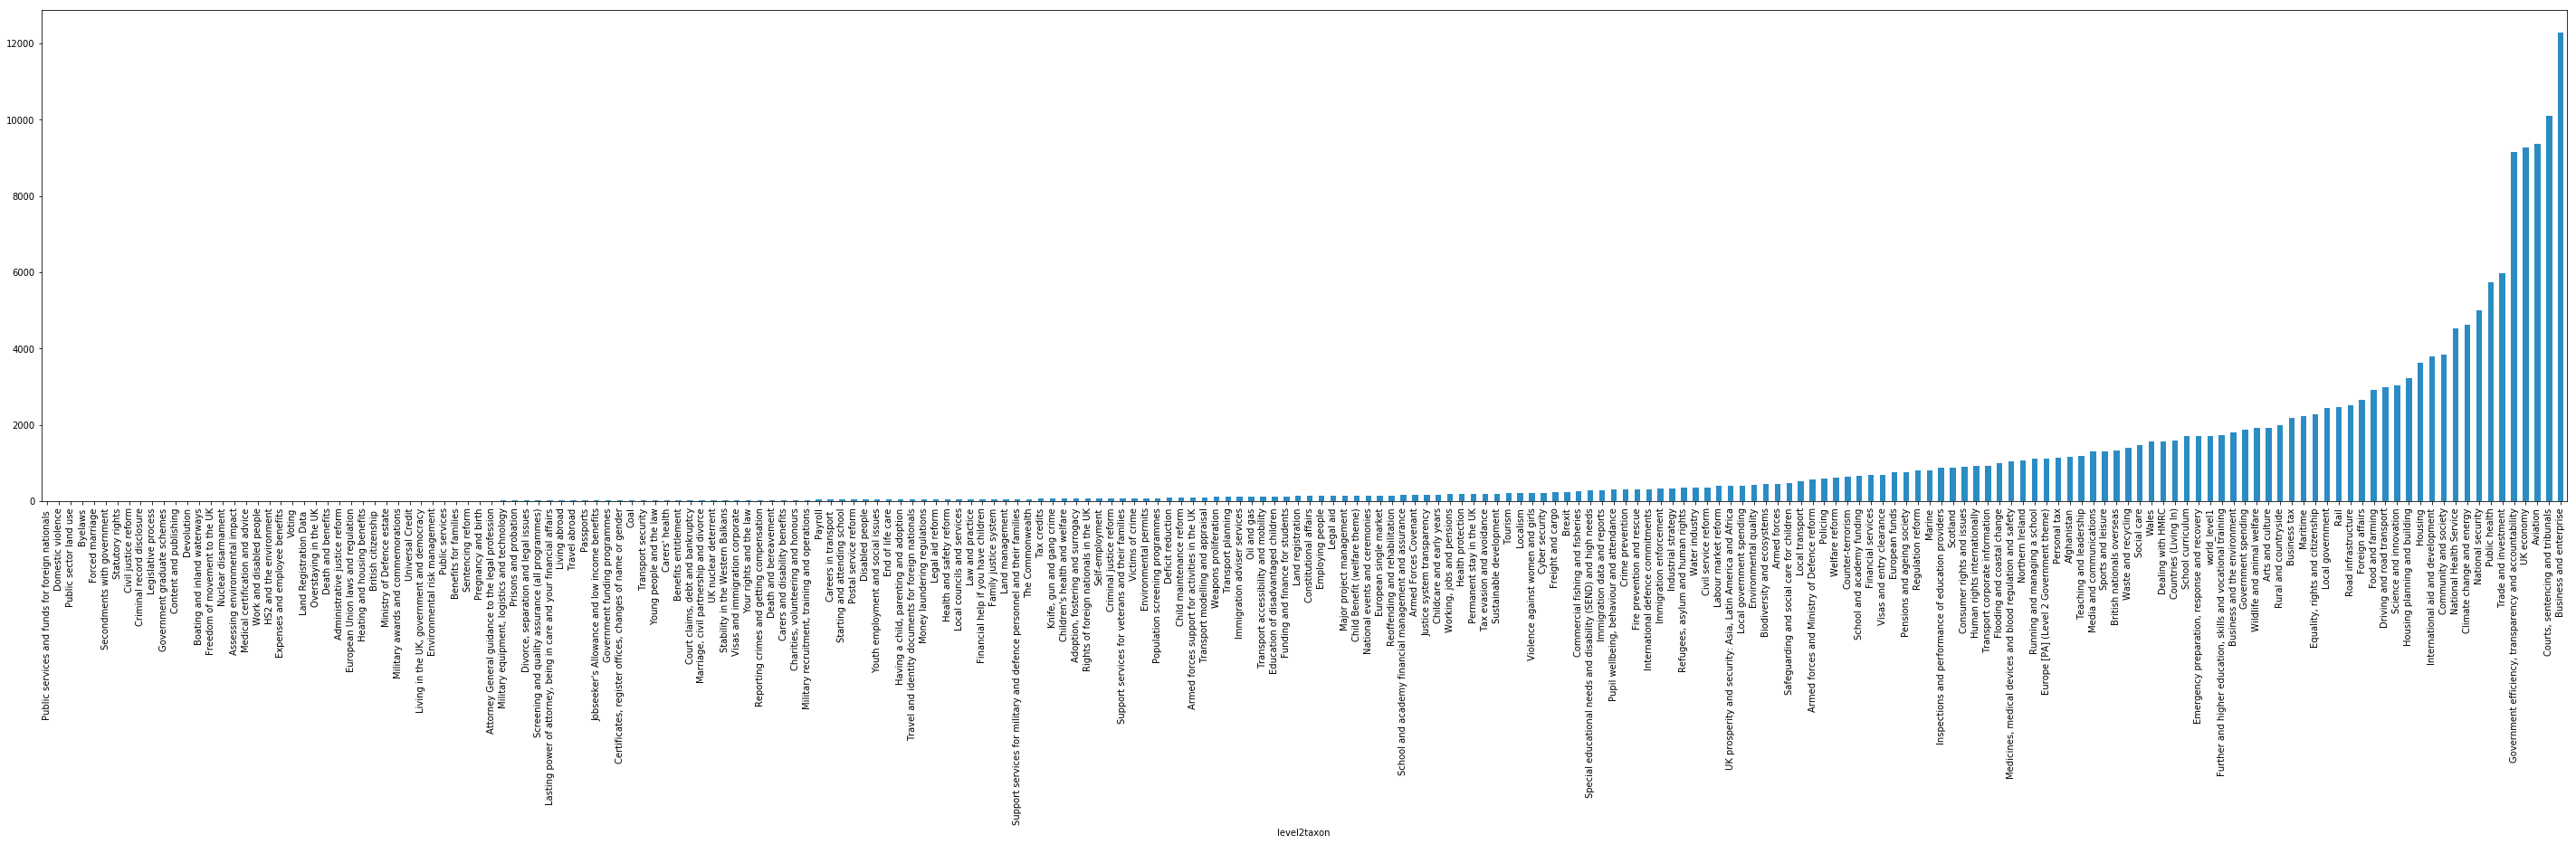

In [10]:
labelled_level2.groupby('level2taxon').size().sort_values(ascending=True).plot(kind='bar', figsize=(50,10), color='#2B8CC4')

### Load in data

In [11]:
true_train = pd.read_csv(os.path.join(DATADIR, 'true_train.csv.gz'), dtype=float, compression='gzip')
pred_train = pd.read_csv(os.path.join(DATADIR, 'train_results.csv.gz'), dtype=float, compression='gzip')

In [12]:
true_dev = pd.read_csv(os.path.join(DATADIR, 'true_dev.csv.gz'), dtype=float, compression='gzip')
prob_dev = pd.read_csv(os.path.join(DATADIR, 'dev_results.csv.gz'), dtype=float, compression='gzip')

In [13]:
train = np.load(os.path.join(DATADIR, 'train_arrays.npz'))

In [14]:
dev = np.load(os.path.join(DATADIR, 'dev_arrays.npz'))

In [15]:
labelled_level2.loc[labelled_level2['content_id'].isin(train['content_id'])]

,base_path,content_id,content_purpose_document_supertype,content_purpose_subgroup,content_purpose_supergroup,description,details,document_type,email_document_supertype,first_published_at,...,combined_text,taxon_id,taxon_base_path,taxon_name,level1taxon,level2taxon,level3taxon,level4taxon,level5taxon,level2taxon_code
0,/government/news/optimo-wins-contract-with-mal...,5ef82615-7631-11e4-a3cb-005056011aef,news,news,news_and_communications,ukti malaysia helps software company optimo wi...,"{'body': '<div class=""govspeak""><p><a rel=""ext...",world_news_story,announcements,2014-01-16 08:58:34.000,...,optimo wins contract with malaysian f1 circuit...,21eee04d-e702-4e7b-9fde-2f6777f1be2c,/business/business-and-enterprise,Business and enterprise,Business,Business and enterprise,NaN,NaN,NaN,19
2,/government/news/uk-pavilion-at-expomin-2016-i...,002263ed-810b-4a5f-a8f9-441cdf137876,news,news,news_and_communications,chilean mining minister aurora williams and am...,"{'body': '<div class=""govspeak""><p>Chilean Pre...",world_news_story,announcements,2016-04-27 13:57:00.000,...,uk pavilion at expomin 2016 inaugurated in chi...,21eee04d-e702-4e7b-9fde-2f6777f1be2c,/business/business-and-enterprise,Business and enterprise,Business,Business and enterprise,NaN,NaN,NaN,19
3,/government/news/joint-statement-by-the-uk-and...,b5bf2835-1405-4760-9e23-109d256b2a44,news,news,news_and_communications,a joint statement on the visit to vietnam of t...,"{'body': '<div class=""govspeak""><p>At the invi...",world_news_story,announcements,2015-07-30 01:00:00.000,...,joint statement by the uk and vietnam on uk pr...,21eee04d-e702-4e7b-9fde-2f6777f1be2c,/business/business-and-enterprise,Business and enterprise,Business,Business and enterprise,NaN,NaN,NaN,19
4,/government/news/arlene-foster-northern-irelan...,601af081-7631-11e4-a3cb-005056011aef,news,news,news_and_communications,heavenly tasty organics has begun supplying a ...,"{'body': '<div class=""govspeak""><p>Northern Ir...",world_news_story,announcements,2014-09-18 09:40:08.000,...,arlene foster: northern ireland companies winn...,21eee04d-e702-4e7b-9fde-2f6777f1be2c,/business/business-and-enterprise,Business and enterprise,Business,Business and enterprise,NaN,NaN,NaN,19
5,/government/news/british-embassy-manila-call-f...,5e2f2dbc-7631-11e4-a3cb-005056011aef,news,news,news_and_communications,the british embassy is inviting organisations ...,"{'body': '<div class=""govspeak"">\n<p>The Briti...",world_news_story,announcements,2013-05-23 04:44:00.000,...,british embassy manila: call for bids to the p...,21eee04d-e702-4e7b-9fde-2f6777f1be2c,/business/business-and-enterprise,Business and enterprise,Business,Business and enterprise,NaN,NaN,NaN,19
6,/government/news/chile-day-to-take-place-in-lo...,6d81b7c7-b8d9-47bb-a8e9-2e3691f523b1,news,news,news_and_communications,statement by ambassador fiona clouder announci...,"{'body': '<div class=""govspeak""><p>Today is a ...",world_news_story,announcements,2017-03-28 19:07:00.000,...,chile day to take place in london in june 2017...,21eee04d-e702-4e7b-9fde-2f6777f1be2c,/business/business-and-enterprise,Business and enterprise,Business,Business and enterprise,NaN,NaN,NaN,19
7,/government/news/queen-elizabeth-ii-awards-jes...,5371ec81-e307-4de0-a25d-56b16e17722d,news,news,news_and_communications,her majesty queen elizabeth ii has recognised ...,"{'body': '<div class=""govspeak""><p>Her Majesty...",world_news_story,announcements,2017-04-10 06:01:30.000,...,queen elizabeth ii awards jesus paraiso tambun...,21eee04d-e702-4e7b-9fde-2f6777f1be2c,/business/business-and-enterprise,Business and enterprise,Business,Business and enterprise,NaN,NaN,NaN,19
9,/government/news/ricardo-celebrates-100-years-...,c29ce436-2825-459d-b015-3eb0f354d6b8,news,news,news_and_communications,the ‘ricardo100 global challenge’ showcases th...,"{'body': '<div class=""govspeak""><p>British aut...",world_news_story,announcements,2015-05-28 10:39:00.000,...,ricardo celebrates 100 years and a ‘great 

In [16]:
labelled_level2.level2taxon.nunique()

216

### Evaluate model

#### Training metrics

In [17]:
y_pred = pred_train.copy()

In [18]:
y_pred[y_pred>=P_THRESHOLD] = 1
y_pred[y_pred<P_THRESHOLD] = 0

In [19]:
print('micro: {}'.format(precision_recall_fscore_support(true_train, y_pred, average='micro', sample_weight=None)))
print('macro: {}'.format(precision_recall_fscore_support(true_train, y_pred, average='macro', sample_weight=None)))
print('weightedmacro: {}'.format(precision_recall_fscore_support(true_train, y_pred, average='weighted', sample_weight=None)))

micro: (0.960872218648457, 0.95438341262664, 0.9576168237357623, None)
macro: (0.9761239031892066, 0.9716207119987411, 0.973593605953846, None)
weightedmacro: (0.9614254078819213, 0.95438341262664, 0.9574775127025943, None)


In [20]:
eval_metrics = precision_recall_fscore_support(true_train, y_pred, average=None, sample_weight=None)
eval_metrics_df = pd.DataFrame(list(eval_metrics))

In [21]:
train_metrics = eval_metrics_df.transpose()
train_metrics.columns = ['precision', 'recall', 'f1', 'support']
train_metrics['level2code'] = train_metrics.index +1
train_metrics['level2label'] = train_metrics['level2code'].map(labels_index)

In [22]:
train_metrics.head()

,precision,recall,f1,support,level2code,level2label
0,1.000000,1.000000,1.000000,523.0,1,Administrative justice reform
1,0.990281,1.000000,0.995117,917.0,2,"Adoption, fostering and surrogacy"
2,0.975258,0.967280,0.971253,978.0,3,Afghanistan
3,0.965659,0.983217,0.974359,715.0,4,Armed Forces Covenant
4,1.000000,1.000000,1.000000,1166.0,5,Armed forces


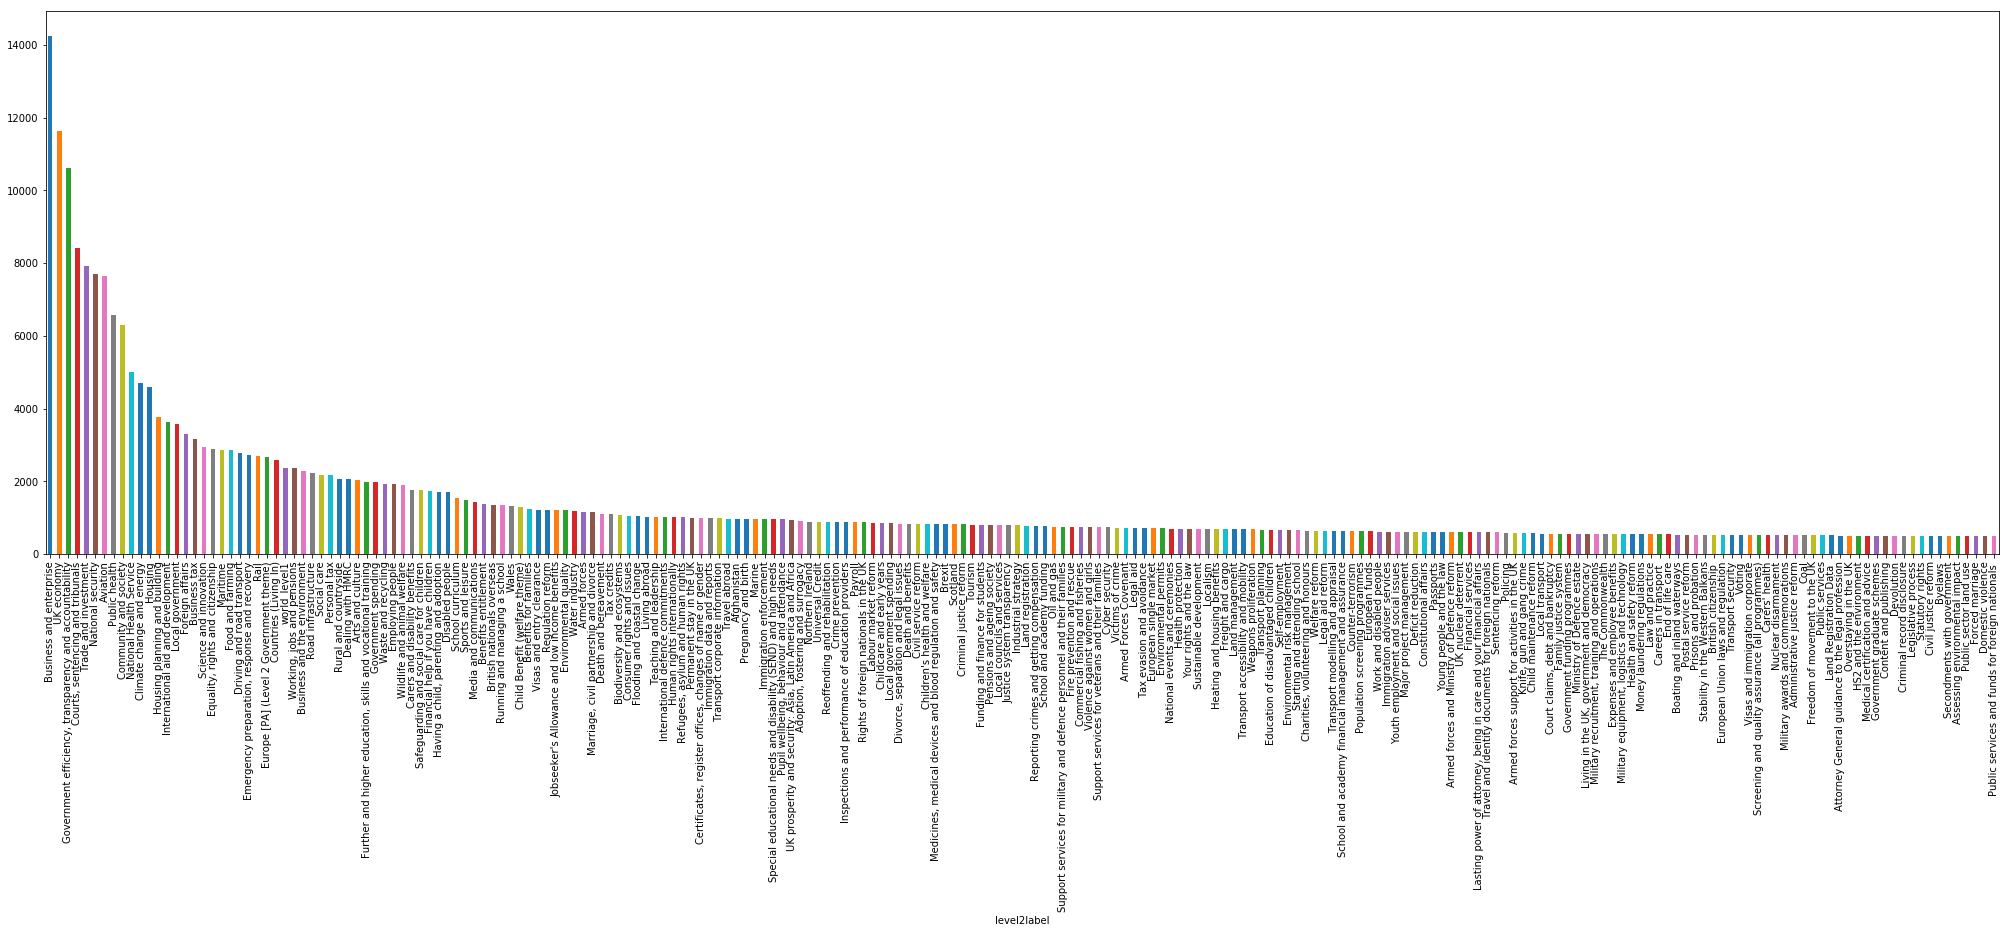

In [23]:
train_metrics.sort_values('support', ascending=False).plot(x='level2label', y='support', kind = 'bar', figsize=(35,10), legend=False)

#### Development set metrics

In [24]:
pred_dev = prob_dev.copy()

In [25]:
pred_dev[pred_dev>=P_THRESHOLD] = 1
pred_dev[pred_dev<P_THRESHOLD] = 0

In [26]:
print('micro: {}'.format(precision_recall_fscore_support(true_dev, pred_dev, average='micro', sample_weight=None)))
print('macro: {}'.format(precision_recall_fscore_support(true_dev, pred_dev, average='macro', sample_weight=None)))
print('weightedmacro: {}'.format(precision_recall_fscore_support(true_dev, pred_dev, average='weighted', sample_weight=None)))

micro: (0.8404935755929134, 0.8221127228435389, 0.831201544963475, None)
macro: (0.8019049949508937, 0.8572686617176201, 0.820009871197373, None)
weightedmacro: (0.8454191132958824, 0.8221127228435389, 0.8300245073317564, None)


/home/ubuntu/ellie/govuk-taxonomy-supervised-learning/.direnv/python-3.6.3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/ellie/govuk-taxonomy-supervised-learning/.direnv/python-3.6.3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [27]:
eval_metrics = precision_recall_fscore_support(true_dev, pred_dev, average=None, sample_weight=None)
eval_metrics_df = pd.DataFrame(list(eval_metrics))

/home/ubuntu/ellie/govuk-taxonomy-supervised-learning/.direnv/python-3.6.3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/ellie/govuk-taxonomy-supervised-learning/.direnv/python-3.6.3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [28]:
dev_metrics = eval_metrics_df.transpose()
dev_metrics.columns = ['precision', 'recall', 'f1', 'support']
dev_metrics['taxon2code'] = dev_metrics.index +1
dev_metrics['taxon2label'] = dev_metrics['taxon2code'].map(labels_index)

In [68]:
dev_metrics['tagged_to'] = np.where(((dev_metrics['taxon2label'] == 'Arts and culture')|(dev_metrics['taxon2label'] == 'UK economy') | (dev_metrics['taxon2label'] == 'Media and communications')), 'no', 'yes')

In [59]:
dev_metrics.dtypes

precision      float64
recall         float64
f1             float64
support        float64
taxon2code       int64
taxon2label     object
tagged_to        int64
dtype: object

In [30]:
chart = alt.Chart(dev_metrics).mark_point().encode(
    x='support',
    y='f1',
    tooltip=['taxon2label:N', 'support:Q', 'f1:Q'], 
    color = 'tagged_to:N'
).properties(
title = 'Original model, level 2 branches, data = 27/03/18')
chart.save('historical_tag_results.html')

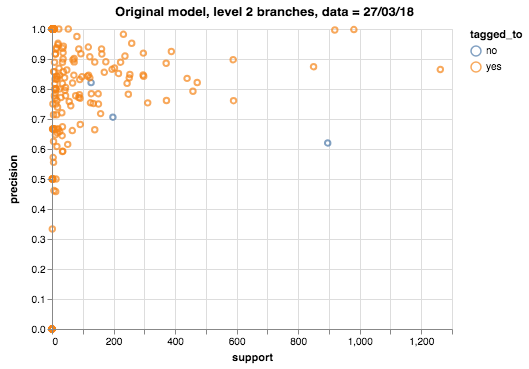

In [69]:
chart = alt.Chart(dev_metrics).mark_point().encode(
    x='support',
    y='precision',
    tooltip=['taxon2label:N', 'support:Q', 'f1:Q', 'precision:Q'], 
    color = 'tagged_to:N'
).properties(
title = 'Original model, level 2 branches, data = 27/03/18')
chart

In [31]:
dev_metrics.sort_values('f1', ascending=True)

,precision,recall,f1,support,taxon2code,taxon2label,tagged_to
150,0.000000,0.000000,0.000000,0.0,151,Public sector land use,0
39,0.000000,0.000000,0.000000,0.0,40,Content and publishing,0
21,0.000000,0.000000,0.000000,0.0,22,Byelaws,0
125,0.000000,0.000000,0.000000,0.0,126,Medical certification and advice,0
52,0.000000,0.000000,0.000000,0.0,53,Devolution,0
169,0.000000,0.000000,0.000000,0.0,170,Screening and quality assurance (all programmes),0
170,0.000000,0.000000,0.000000,0.0,171,Secondments with government,0
60,0.000000,0.000000,0.000000,0.0,61,End of life care,0
172,0.000000,0.000000,0.000000,0.0,173,Sentencing reform,0
31,0.000000,0.000000,0.000000,0.0,32,Civil justice reform,0


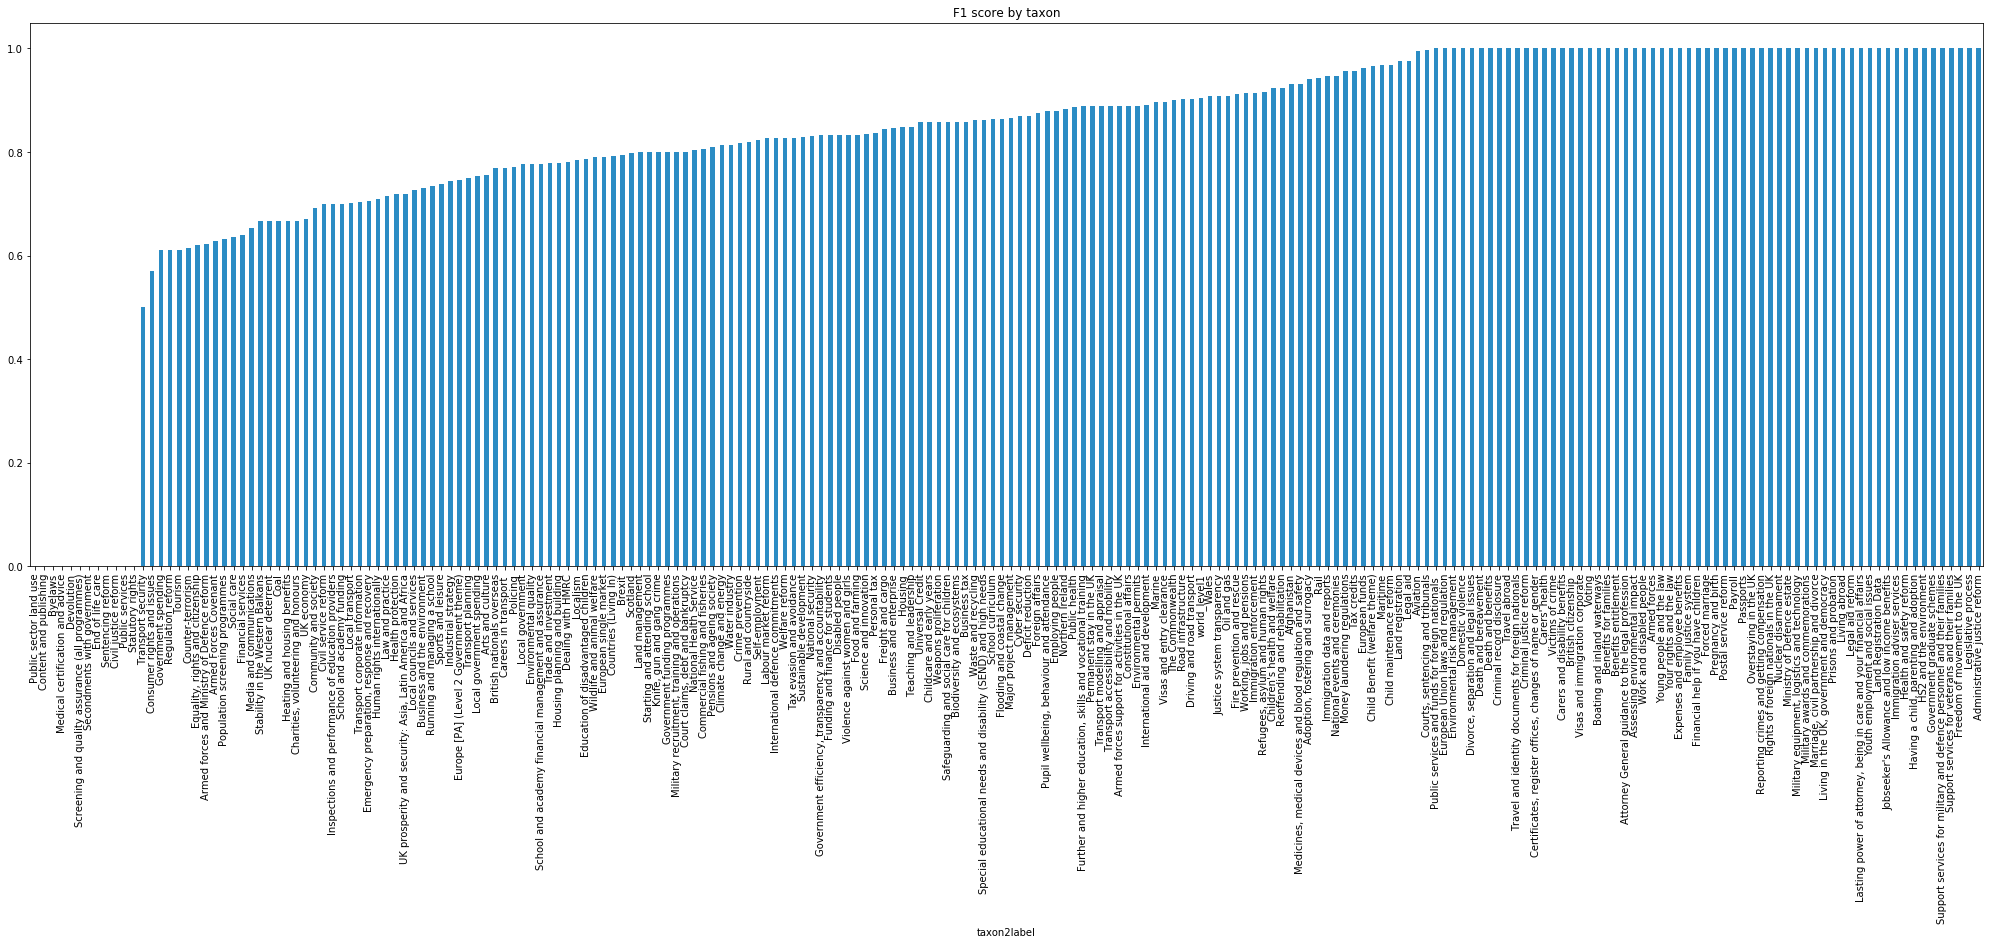

In [32]:
dev_metrics.sort_values('f1', ascending=True).plot(x='taxon2label', y='f1', kind = 'bar', figsize=(35, 10), legend=False, title='F1 score by taxon', color='#2B8CC4')

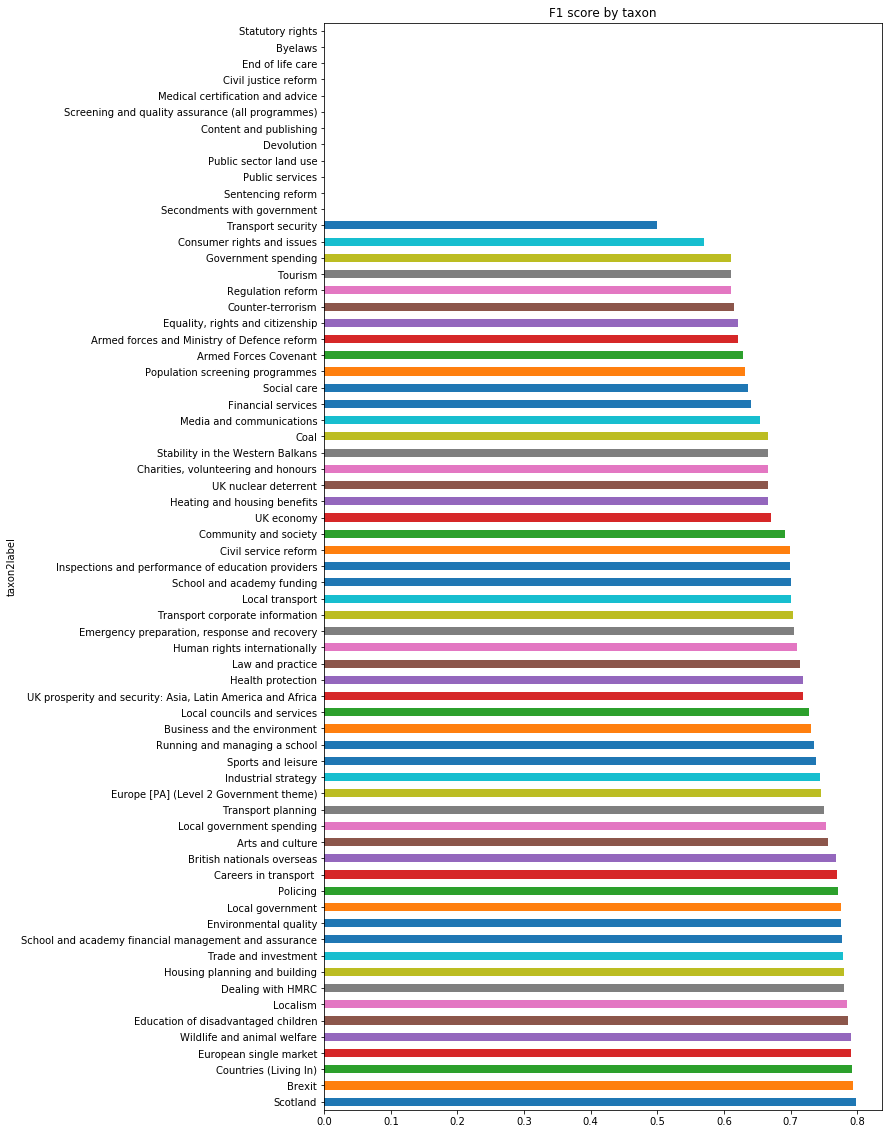

In [33]:
dev_metrics[dev_metrics['f1']<0.8].sort_values('f1', ascending=False).plot(x='taxon2label', y='f1', kind = 'barh', figsize=(10,20), legend=False, title='F1 score by taxon')

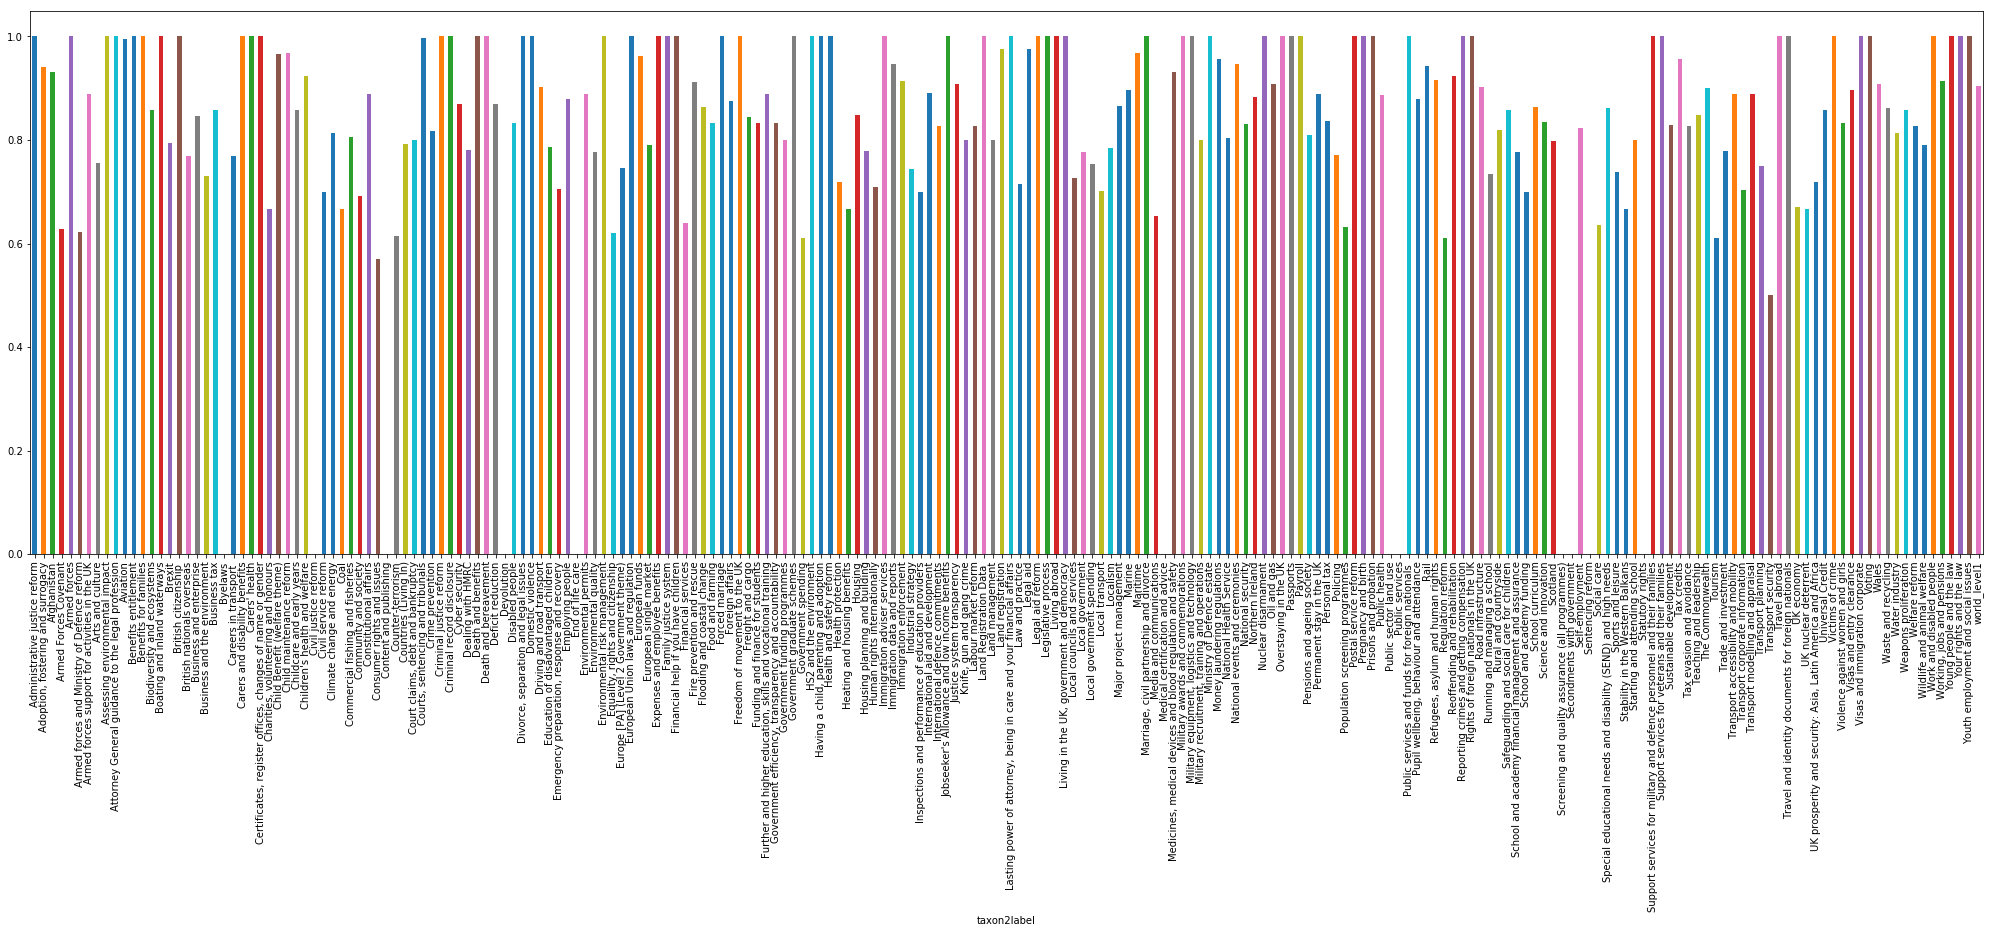

In [34]:
dev_metrics.sort_values('taxon2label', ascending=True).plot(x='taxon2label', y='f1', kind = 'bar', figsize=(35,10), legend=False)

In [35]:
dev_metrics[dev_metrics['f1']==0].shape[0]

12

In [36]:
dev_metrics[(dev_metrics['f1']<0.8) & (dev_metrics['f1']>0)].shape[0]

55

In [37]:
dev_metrics[dev_metrics['f1']==1].shape[0]

61

In [38]:
dev_metrics[dev_metrics['f1']==1]

,precision,recall,f1,support,taxon2code,taxon2label,tagged_to
0,1.0,1.0,1.0,2.0,1,Administrative justice reform,0
4,1.0,1.0,1.0,53.0,5,Armed forces,0
8,1.0,1.0,1.0,1.0,9,Assessing environmental impact,0
9,1.0,1.0,1.0,3.0,10,Attorney General guidance to the legal profession,0
11,1.0,1.0,1.0,5.0,12,Benefits entitlement,0
12,1.0,1.0,1.0,2.0,13,Benefits for families,0
14,1.0,1.0,1.0,1.0,15,Boating and inland waterways,0
16,1.0,1.0,1.0,2.0,17,British citizenship,0
23,1.0,1.0,1.0,7.0,24,Carers and disability benefits,0
24,1.0,1.0,1.0,2.0,25,Carers' health,0


In [39]:
dev_metrics.to_csv(os.path.join(DATADIR, "dev_metrics.csv.gz"), compression='gzip',index=False)

In [40]:
high = dev_metrics[dev_metrics['f1']>0.9]

In [41]:
morethan80 = dev_metrics[dev_metrics['f1']>0.8]

In [42]:
dev_metrics[dev_metrics['f1']<0.6].shape[0]

14

In [43]:
dev_metrics[dev_metrics['f1']<0.8].shape

(67, 7)

In [44]:
dev_metrics[dev_metrics['f1']==0].shape

(12, 7)

In [45]:
dev_metrics[dev_metrics['taxon2label']=='UK economy']

,precision,recall,f1,support,taxon2code,taxon2label,tagged_to
195,0.620265,0.731027,0.671107,896.0,196,UK economy,1


## support and performance

The support is the number of occurrences of each class in y_true

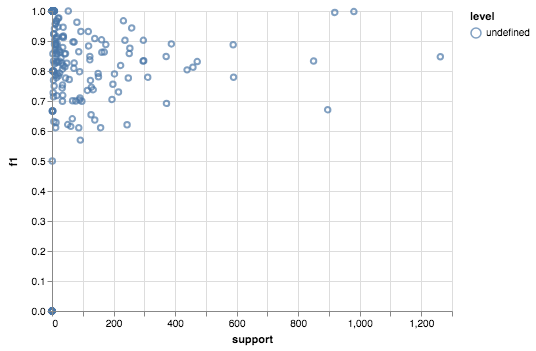

In [46]:
alt.Chart(dev_metrics).mark_point().encode(
    x='support',
    y='f1',
    tooltip=['taxon2label:N'], 
    color='level:N'
)

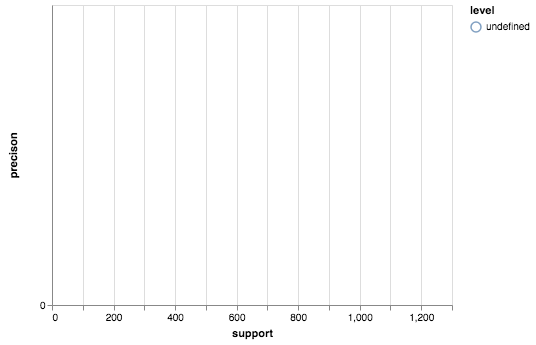

In [56]:
alt.Chart(dev_metrics).mark_point().encode(
    x='support',
    y='precison:Q',
    tooltip=['taxon2label:N'], 
    color='level:N'
)

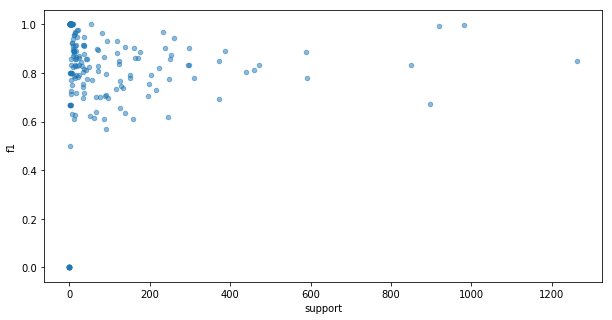

In [48]:
dev_metrics.plot.scatter(x='support', y='f1', marker='o', alpha=.5, figsize=(10, 5))


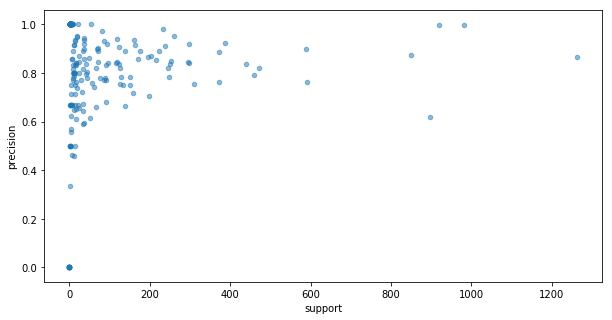

In [49]:
dev_metrics.plot.scatter(x='support', y='precision', marker='o', alpha=.5, figsize=(10, 5))


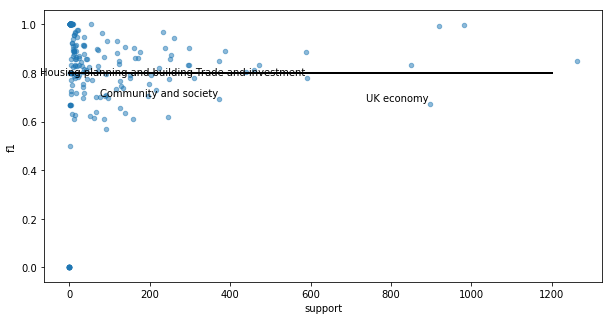

In [50]:
dev_metrics.plot.scatter(x='support', y='f1', marker='o', alpha=.5, figsize=(10, 5))
plt.plot([0, 1200],[0.8, 0.8],  'k-', lw=2)

for label, x, y in zip(dev_metrics['taxon2label'], dev_metrics['support'], dev_metrics['f1']):
    if (x>300 and y<0.8):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-1, 1),
            textcoords='offset points', ha='right', va='bottom')
    if (y==1):
        label = ""
        plt.annotate(
            label,
            xy=(x, y), xytext=(-1, 1),
            textcoords='offset points', ha='right', va='bottom')
        
plt.show()

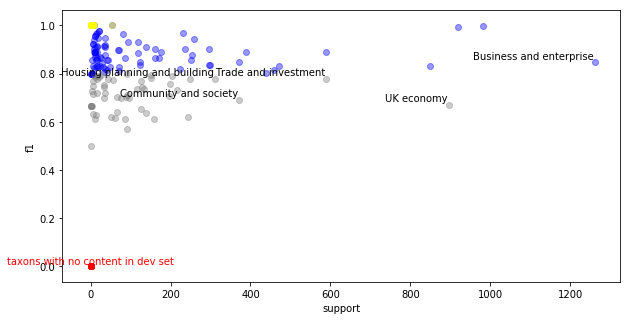

In [51]:
# normal values
plt.figure(figsize=(10, 5))
plt.text(0, 0, "taxons with no content in dev set", color='red', horizontalalignment='center', 
         verticalalignment='bottom')
plt.xlabel('support')
plt.ylabel('f1')
plt.scatter(dev_metrics['support'][dev_metrics['f1']>=0.8], 
            dev_metrics['f1'][dev_metrics['f1']>=0.8], 
            c = 'b', 
            alpha=.4)
# less than 0.8
plt.scatter(dev_metrics['support'][dev_metrics['f1']<0.8], 
            dev_metrics['f1'][dev_metrics['f1']<0.8], 
            c = 'grey', 
            alpha=.4)

plt.scatter(dev_metrics['support'][dev_metrics['f1']==0], 
            dev_metrics['f1'][dev_metrics['f1']==0], 
            c = 'red', 
            alpha=.4)
plt.scatter(dev_metrics['support'][dev_metrics['f1']==1], 
            dev_metrics['f1'][dev_metrics['f1']==1], 
            c = 'yellow', 
            alpha=.4)


for label, x, y in zip(dev_metrics['taxon2label'], dev_metrics['support'], dev_metrics['f1']):
    if ((x>300 and y<0.8) or (x>1000)):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-1, 1),
            textcoords='offset points', ha='right', va='bottom')
    if (y==1):
        label = ""
        plt.annotate(
            label,
            xy=(x, y), xytext=(-1, 1),
            textcoords='offset points', ha='right', va='bottom')


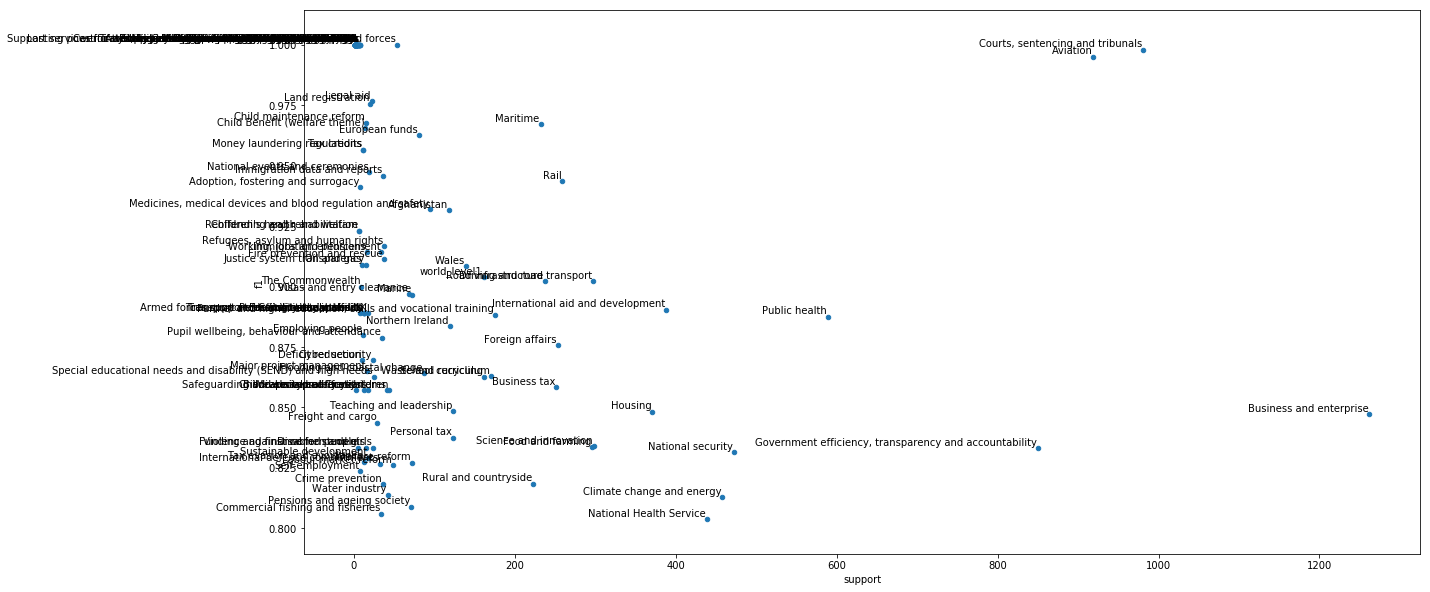

In [52]:
morethan80.plot.scatter(x='support', y='f1', figsize=(20, 10))

for label, x, y in zip(morethan80['taxon2label'], morethan80['support'], morethan80['f1']):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-1, 1),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

### look at content predicted in taxons with f1=1

In [53]:
prob_dev.head()

,1,2,3,4,5,6,7,8,9,10,...,207,208,209,210,211,212,213,214,215,216
0,5.975111e-20,1.344386e-28,7.869623e-32,2.307543e-27,1.468768e-19,1.881139e-23,6.481651e-25,1.675889e-19,3.255599e-18,2.352345e-20,...,5.565174e-18,2.282563e-21,4.738145e-36,1.147764e-06,1.312217e-20,6.642663e-22,1.603932e-30,4.549276e-24,7.540052e-38,1.825356e-17
1,5.732123e-08,6.318110e-11,2.544885e-12,4.405345e-15,1.946344e-11,6.859637e-13,9.034998e-14,9.493716e-10,2.175588e-13,4.378722e-08,...,5.269347e-09,3.597979e-12,4.717775e-13,2.103488e-08,2.508323e-08,9.827555e-08,1.294633e-10,1.152133e-07,1.860319e-09,6.609049e-10
2,1.977971e-15,1.426294e-12,3.198320e-20,4.463624e-21,7.614991e-19,7.426197e-20,9.209342e-23,9.689971e-15,1.541543e-17,7.399977e-14,...,6.737664e-18,5.004887e-18,3.967241e-15,3.431120e-16,1.206307e-17,8.931657e-15,8.383405e-13,1.581794e-13,1.879088e-12,1.808200e-13
3,5.928680e-35,9.348985e-37,0.000000e+00,0.000000e+00,1.492227e-35,3.067319e-37,0.000000e+00,0.000000e+00,5.534523e-24,7.608345e-33,...,9.445454e-29,0.000000e+00,0.000000e+00,3.277408e-24,1.979778e-28,4.412728e-23,2.910099e-31,4.561360e-36,0.000000e+00,2.016838e-22
4,2.493460e-34,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.266348e-30,0.000000e+00,5.767959e-32,...,0.000000e+00,0.000000e+00,0.000000e+00,2.012623e-32,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.254951e-30


In [54]:
dev_metrics[dev_metrics['f1']==1].head()

,precision,recall,f1,support,taxon2code,taxon2label,tagged_to
0,1.0,1.0,1.0,2.0,1,Administrative justice reform,0
4,1.0,1.0,1.0,53.0,5,Armed forces,0
8,1.0,1.0,1.0,1.0,9,Assessing environmental impact,0
9,1.0,1.0,1.0,3.0,10,Attorney General guidance to the legal profession,0
11,1.0,1.0,1.0,5.0,12,Benefits entitlement,0


In [55]:
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

NameError: name 'y_test' is not defined